# Modeling Notebook with Balanced Dataset

In [19]:
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pickle
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from sklearn import linear_model, utils
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, classification_report,balanced_accuracy_score, precision_recall_curve, plot_precision_recall_curve
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
import string

import multiprocessing
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence, TaggedDocument

%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("../py")
from utils import *


In [2]:
train = pickle.load(open("../pickle/train_bal.pickle", "rb"))
val = pickle.load(open("../pickle/val_bal.pickle", "rb"))

In [5]:
train.head()
train.columns = ['tweet', 'target']

In [6]:
train.target.value_counts()

0    17514
1     8838
Name: target, dtype: int64

In [7]:
val.columns = ['tweet', 'target']
val.head()

,tweet,target
0,"[pakistan, wear, black, band, oppose, israel, ...",1
1,"[winner, popular, vote, russian, conspiracy, r...",1
2,"[girl, fucktrump]",1
3,"[iphone, pocket, scratchy, things, scratch, sc...",1
4,"[beyonc, trash]",1


In [9]:
train.tweet = train.tweet.apply(lambda x: str(x)[1:-1]) 
val.tweet = val.tweet.apply(lambda x: str(x)[1:-1]) 

In [10]:
X_tr = train.tweet
X_val = val.tweet
y_tr = train.target
y_val = val.target

vec = TfidfVectorizer()
tfidf_tr = vec.fit_transform(X_tr)
tfidf_val = vec.transform(X_val)

Train Accuracy:  0.9189814814814815
Val Accuracy:  0.895066413662239
Train F1:  0.8643152208452494
Val F1:  0.8193400849395622
Train ROC-AUC:  0.961930672059514
Val ROC-AUC:  0.9393149311262187
Train Recall:  0.7694048427245983
Vali Recall:  0.7096774193548387
Train Precision:  0.9859359141655792
Val Precision:  0.9690880989180835
Train PR-AUC:  0.9553774007585114
Val PR-AUC:  0.9256200246945678


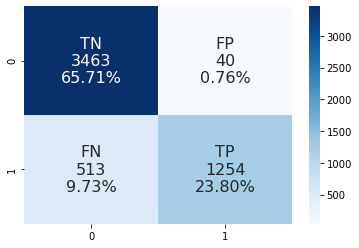

In [12]:
nb = MultinomialNB().fit(tfidf_tr, y_tr)
y_pr_nb_tr = nb.predict(tfidf_tr)
y_pr_nb_val = nb.predict(tfidf_val)
get_metrics(tfidf_tr, y_tr, tfidf_val, y_val, y_pr_nb_tr, y_pr_nb_val, nb)

## Random Forest Classifier

Train Accuracy:  0.9981785063752276
Val Accuracy:  0.9187855787476281
Train F1:  0.9972847607195385
Val F1:  0.8734476641040804
Train ROC-AUC:  0.9998811089168946
Val ROC-AUC:  0.9627247305688826
Train Recall:  0.9973976012672551
Vali Recall:  0.8358800226372383
Train Precision:  0.9971719457013575
Val Precision:  0.9145510835913313
Train PR-AUC:  0.9997779700667732
Val PR-AUC:  0.9504302337850982


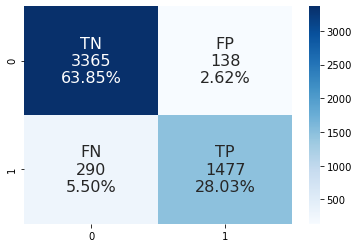

In [14]:
rf = RandomForestClassifier(n_estimators=100).fit(tfidf_tr, y_tr)
y_pr_rf_tr = rf.predict(tfidf_tr)
y_pr_rf_val = rf.predict(tfidf_val)
get_metrics(tfidf_tr, y_tr, tfidf_val, y_val, y_pr_rf_tr, y_pr_rf_val, rf)

## Logistic Regression

Train Accuracy:  0.9552216150576807
Val Accuracy:  0.9240986717267552
Train F1:  0.9305473808122425
Val F1:  0.8815165876777252
Train ROC-AUC:  0.9802501773837128
Val ROC-AUC:  0.9655929972546775
Train Recall:  0.8944331296673456
Vali Recall:  0.8421052631578947
Train Precision:  0.9697006869479883
Val Precision:  0.9247980111870727
Train PR-AUC:  0.9759206773971545
Val PR-AUC:  0.9553816390623809


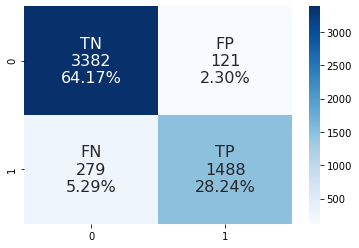

In [15]:
log = LogisticRegression().fit(tfidf_tr, y_tr)
y_pr_log_tr = log.predict(tfidf_tr)
y_pr_log_val = log.predict(tfidf_val)
get_metrics(tfidf_tr, y_tr, tfidf_val, y_val, y_pr_log_tr, y_pr_log_val, log)

In [20]:
train['target2'] = np.nan
train.loc[train.target == 1, 'target2'] = 'Hate'
train.loc[train.target == 0, 'target2'] = 'Not_Hate'

In [21]:
val['target2'] = np.nan
val.loc[val.target == 1, 'target2'] = 'Hate'
val.loc[val.target == 0, 'target2'] = 'Not_Hate'

In [22]:
train_tagged = train.apply(lambda x: TaggedDocument(words=x['tweet'], tags=x.target2), axis=1)
train_tagged.values[30]

TaggedDocument(words="'tell', 'fuck', 'girls', 'hot', 'mkr', 'cuntofahead'", tags='Hate')

In [23]:
val_tagged = val.apply(lambda x: TaggedDocument(words=x['tweet'], tags=x.target2), axis=1)
val_tagged.values[30]

TaggedDocument(words="'oppose', 'saudi', 'arabia', 'kill', 'gay', 'horrific', 'place', 'prepare', 'support'", tags='Hate')

In [24]:
cores = multiprocessing.cpu_count()
model_dbow = Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 26352/26352 [00:00<00:00, 2648209.00it/s]


In [25]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 26352/26352 [00:00<00:00, 3643830.12it/s]
CPU times: user 1min 12s, sys: 4.55 s, total: 1min 16s
Wall time: 28.5 s


In [26]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [27]:
y_tr, X_tr = vec_for_learning(model_dbow, train_tagged)
y_val, X_val = vec_for_learning(model_dbow, val_tagged)

TypeError: Parameter doc_words of infer_vector() must be a list of strings (not a single string).